In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import sys

# sys.path.append(f'C:\Users\VJ\Desktop\MyCode\Git Clones!!\Open3D-master\python\')

# import open3d_tutorial as o3dtut

# o3d.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print("Read Redwood dataset")
redwood_rgbd = o3d.data.SampleRedwoodRGBDImages()
color_raw = o3d.io.read_image(redwood_rgbd.color_paths[0])
depth_raw = o3d.io.read_image(redwood_rgbd.depth_paths[0])
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)

Read Redwood dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


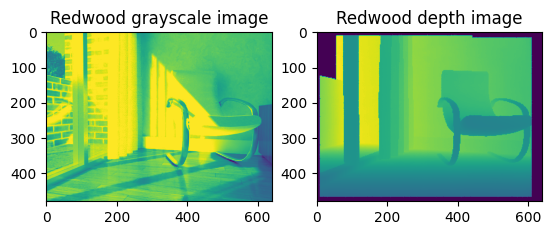

In [3]:
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [5]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

In [1]:
import cv2
import torch
import numpy as np
import open3d as o3d

# Load the MiDaS model
model_type = "DPT_Hybrid"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

# Load the transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

# Open the video capture
cap = cv2.VideoCapture(0)

# Create an empty point cloud
pcd = o3d.geometry.PointCloud()

while cap.isOpened():
    success, img = cap.read()
    if not success:
        break

    # Convert the image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Generate the depth map
    input_batch = transform(img_rgb).to(device)
    with torch.no_grad():
        depth_map = midas(input_batch)

    # Convert the depth map to a point cloud
    depth_map = depth_map.squeeze().cpu().numpy()
    color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    points = np.array(np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))).reshape(2, -1).T
    points = np.hstack((points, depth_map.reshape(-1, 1)))
    colors = color.reshape(-1, 3) / 255

    # Add the point cloud to the combined point cloud
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)

cap.release()

# Save the combined point cloud
o3d.io.write_point_cloud("combined.ply", pcd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Using cache found in C:\Users\VJ/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\VJ\anaconda3\envs\model-3d\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in C:\Users\VJ/.cache\torch\hub\intel-isl_MiDaS_master


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 307200 and the array at index 1 has size 196608